# Pizza Place Sales — Complete Analysis

This notebook performs a full analysis of the `Pizza+Place+Sales.zip` dataset. It loads the four CSV files (Orders, Order Details, Pizzas, Pizza Types), merges them into a single line-level dataframe, performs cleaning and validation, and answers the recommended questions with charts and explanations.

**Sections:**
1. Load data
2. Data inspection & cleaning
3. Merge tables
4. Feature engineering (datetime, revenue)
5. Core metrics (revenue, quantities, orders, price)
6. Time-based analysis (hourly, weekday, monthly)
7. Top pizzas and underperforming types
8. Additional explorations (heatmap, price distribution)
9. Conclusions & next steps

The notebook saves key plots to `pizza_plots/`.

In [1]:

# Imports and helper functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from IPython.display import display, Markdown

plt.rcParams['figure.figsize'] = (10,5)

DATA_DIR = Path(r'C:\Users\Jalani.Mevanyi\Music\Tech_Crush_Ass\Task 3\Pizza_Place_Sales_full_package\data')
OUT_PLOTS = Path(r'C:\Users\Jalani.Mevanyi\Music\Tech_Crush_Ass\Task 3\Pizza_Place_Sales_full_package\plots')
OUT_PLOTS.mkdir(parents=True, exist_ok=True)

def read_csv_flexible(path):
    # Read CSV trying multiple encodings and a fallback to replace errors.
    encodings = ['utf-8', 'latin1', 'cp1252']
    for enc in encodings:
        try:
            return pd.read_csv(path, encoding=enc, low_memory=False)
        except Exception:
            pass
    # fallback: read bytes and decode with replacement
    raw = Path(path).read_bytes()
    text = raw.decode('utf-8', errors='replace')
    from io import StringIO
    return pd.read_csv(StringIO(text))


In [2]:

# Load the four CSVs
orders = read_csv_flexible(DATA_DIR / 'orders.csv')
details = read_csv_flexible(DATA_DIR / 'order_details.csv')
pizzas = read_csv_flexible(DATA_DIR / 'pizzas.csv')
types = read_csv_flexible(DATA_DIR / 'pizza_types.csv')
data_dictionary = read_csv_flexible(Path(r'C:\Users\Jalani.Mevanyi\Music\Tech_Crush_Ass\Task 3\Pizza_Place_Sales_full_package\data') / 'data_dictionary.csv')

# Normalize column names
for df in [orders, details, pizzas, types, data_dictionary]:
    df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]

print('Shapes: orders', orders.shape, 'details', details.shape, 'pizzas', pizzas.shape, 'types', types.shape)


Shapes: orders (21350, 3) details (48620, 4) pizzas (96, 4) types (32, 4)


## Data dictionary and sample rows

Below we display the data dictionary and the first few rows of each table to understand the schema.

In [3]:

display(data_dictionary.head(50))
print('\n--- Orders sample ---')
display(orders.head())
print('\n--- Order details sample ---')
display(details.head())
print('\n--- Pizzas sample ---')
display(pizzas.head())
print('\n--- Pizza types sample ---')
display(types.head())


,table,field,description
0,orders,order_id,Unique identifier for each order placed by a t...
1,orders,date,Date the order was placed (entered into the sy...
2,orders,time,Time the order was placed (entered into the sy...
3,order_details,order_details_id,Unique identifier for each pizza placed within...
4,order_details,order_id,Foreign key that ties the details in each orde...
5,order_details,pizza_id,Foreign key that ties the pizza ordered to its...
6,order_details,quantity,Quantity ordered for each pizza of the same ty...
7,pizzas,pizza_id,Unique identifier for each pizza (constituted ...
8,pizzas,pizza_type_id,Foreign key that ties each pizza to its broade...
9,pizzas,size,"Size of the pizza (Small, Medium, Large, X Lar..."



--- Orders sample ---


,order_id,date,time
0,1,2015-01-01,11:38:36
1,2,2015-01-01,11:57:40
2,3,2015-01-01,12:12:28
3,4,2015-01-01,12:16:31
4,5,2015-01-01,12:21:30



--- Order details sample ---


,order_details_id,order_id,pizza_id,quantity
0,1,1,hawaiian_m,1
1,2,2,classic_dlx_m,1
2,3,2,five_cheese_l,1
3,4,2,ital_supr_l,1
4,5,2,mexicana_m,1



--- Pizzas sample ---


,pizza_id,pizza_type_id,size,price
0,bbq_ckn_s,bbq_ckn,S,12.75
1,bbq_ckn_m,bbq_ckn,M,16.75
2,bbq_ckn_l,bbq_ckn,L,20.75
3,cali_ckn_s,cali_ckn,S,12.75
4,cali_ckn_m,cali_ckn,M,16.75



--- Pizza types sample ---


,pizza_type_id,name,category,ingredients
0,bbq_ckn,The Barbecue Chicken Pizza,Chicken,"Barbecued Chicken, Red Peppers, Green Peppers,..."
1,cali_ckn,The California Chicken Pizza,Chicken,"Chicken, Artichoke, Spinach, Garlic, Jalapeno ..."
2,ckn_alfredo,The Chicken Alfredo Pizza,Chicken,"Chicken, Red Onions, Red Peppers, Mushrooms, A..."
3,ckn_pesto,The Chicken Pesto Pizza,Chicken,"Chicken, Tomatoes, Red Peppers, Spinach, Garli..."
4,southw_ckn,The Southwest Chicken Pizza,Chicken,"Chicken, Tomatoes, Red Peppers, Red Onions, Ja..."


## Data checks and basic cleaning
We validate key columns, check for nulls, duplicates, and ensure numeric types for price and quantity.

In [4]:

# Basic checks
for name, df in [('orders', orders), ('details', details), ('pizzas', pizzas), ('types', types)]:
    print(f"{name}: rows={df.shape[0]}, cols={df.shape[1]} | nulls per column:\n", df.isnull().sum(), '\n')

# Check duplicates in details (line items)
print('Duplicate line-items in order details:', details.duplicated().sum())

# Ensure key columns exist
key_cols = {
    'order_id': 'order_id' if 'order_id' in orders.columns else None,
    'details_order_id': 'order_id' if 'order_id' in details.columns else None,
    'pizza_id': 'pizza_id' if 'pizza_id' in pizzas.columns else None,
    'details_pizza_id': 'pizza_id' if 'pizza_id' in details.columns else None
}
print('Detected key columns:', key_cols)


orders: rows=21350, cols=3 | nulls per column:
 order_id    0
date        0
time        0
dtype: int64 

details: rows=48620, cols=4 | nulls per column:
 order_details_id    0
order_id            0
pizza_id            0
quantity            0
dtype: int64 

pizzas: rows=96, cols=4 | nulls per column:
 pizza_id         0
pizza_type_id    0
size             0
price            0
dtype: int64 

types: rows=32, cols=4 | nulls per column:
 pizza_type_id    0
name             0
category         0
ingredients      0
dtype: int64 

Duplicate line-items in order details: 0
Detected key columns: {'order_id': 'order_id', 'details_order_id': 'order_id', 'pizza_id': 'pizza_id', 'details_pizza_id': 'pizza_id'}


## Merge tables into a single line-level dataframe
We start from `order_details` (one row per pizza in an order) and left-join pizzas, types, and orders to enrich each row.

In [5]:

df = details.copy()
# merge pizzas
if 'pizza_id' in df.columns and 'pizza_id' in pizzas.columns:
    df = df.merge(pizzas, on='pizza_id', how='left', suffixes=('','_pizza'))
# merge types
if 'pizza_type_id' in df.columns and 'pizza_type_id' in types.columns:
    df = df.merge(types, on='pizza_type_id', how='left', suffixes=('','_type'))
# merge orders
if 'order_id' in df.columns and 'order_id' in orders.columns:
    df = df.merge(orders, on='order_id', how='left', suffixes=('','_order'))

print('Merged df shape:', df.shape)
display(df.head())


Merged df shape: (48620, 12)


,order_details_id,order_id,pizza_id,quantity,pizza_type_id,size,price,name,category,ingredients,date,time
0,1,1,hawaiian_m,1,hawaiian,M,13.25,The Hawaiian Pizza,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",2015-01-01,11:38:36
1,2,2,classic_dlx_m,1,classic_dlx,M,16.00,The Classic Deluxe Pizza,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",2015-01-01,11:57:40
2,3,2,five_cheese_l,1,five_cheese,L,18.50,The Five Cheese Pizza,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",2015-01-01,11:57:40
3,4,2,ital_supr_l,1,ital_supr,L,20.75,The Italian Supreme Pizza,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",2015-01-01,11:57:40
4,5,2,mexicana_m,1,mexicana,M,16.00,The Mexicana Pizza,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",2015-01-01,11:57:40


## Datetime parsing and feature engineering
Create `order_datetime`, `order_hour`, `order_weekday`, and `order_month` for time-based analysis.

In [6]:

# Create order_datetime from date and time if present
if 'date' in df.columns and 'time' in df.columns:
    df['order_datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str), errors='coerce')
else:
    # try to find any date-like column
    date_cols = [c for c in df.columns if 'date' in c or 'time' in c or 'datetime' in c]
    if date_cols:
        df['order_datetime'] = pd.to_datetime(df[date_cols[0]], errors='coerce')
    else:
        df['order_datetime'] = pd.NaT

df['order_hour'] = df['order_datetime'].dt.hour
df['order_weekday'] = df['order_datetime'].dt.day_name()
df['order_month'] = df['order_datetime'].dt.to_period('M').astype(str)

display(df[['order_id','pizza_id','name','price','quantity','order_datetime']].head())


,order_id,pizza_id,name,price,quantity,order_datetime
0,1,hawaiian_m,The Hawaiian Pizza,13.25,1,2015-01-01 11:38:36
1,2,classic_dlx_m,The Classic Deluxe Pizza,16.00,1,2015-01-01 11:57:40
2,2,five_cheese_l,The Five Cheese Pizza,18.50,1,2015-01-01 11:57:40
3,2,ital_supr_l,The Italian Supreme Pizza,20.75,1,2015-01-01 11:57:40
4,2,mexicana_m,The Mexicana Pizza,16.00,1,2015-01-01 11:57:40


## Compute revenue and ensure numeric types
Compute `line_revenue = price * quantity` and fix types.

In [7]:

# Ensure numeric columns
if 'price' in df.columns:
    df['price'] = pd.to_numeric(df['price'], errors='coerce')
if 'quantity' in df.columns:
    df['quantity'] = pd.to_numeric(df['quantity'], errors='coerce').fillna(0).astype(int)

# Compute revenue
df['line_revenue'] = df['price'].fillna(0) * df['quantity']

# Quick summary
total_revenue = df['line_revenue'].sum()
total_quantity = int(df['quantity'].sum())
total_orders = int(df['order_id'].nunique())
num_pizza_types = int(types.shape[0])
avg_price = float(df['price'].mean()) if 'price' in df.columns else float('nan')

display(Markdown(f"- **Total revenue:** ${total_revenue:,.2f}"))
display(Markdown(f"- **Total quantity sold:** {total_quantity}"))
display(Markdown(f"- **Total orders:** {total_orders}"))
display(Markdown(f"- **Number of pizza types:** {num_pizza_types}"))
display(Markdown(f"- **Average pizza price:** ${avg_price:.2f}"))


- **Total revenue:** $817,860.05

- **Total quantity sold:** 49574

- **Total orders:** 21350

- **Number of pizza types:** 32

- **Average pizza price:** $16.49

## Peak hours and hourly revenue
Plot revenue by hour and find peak hours.

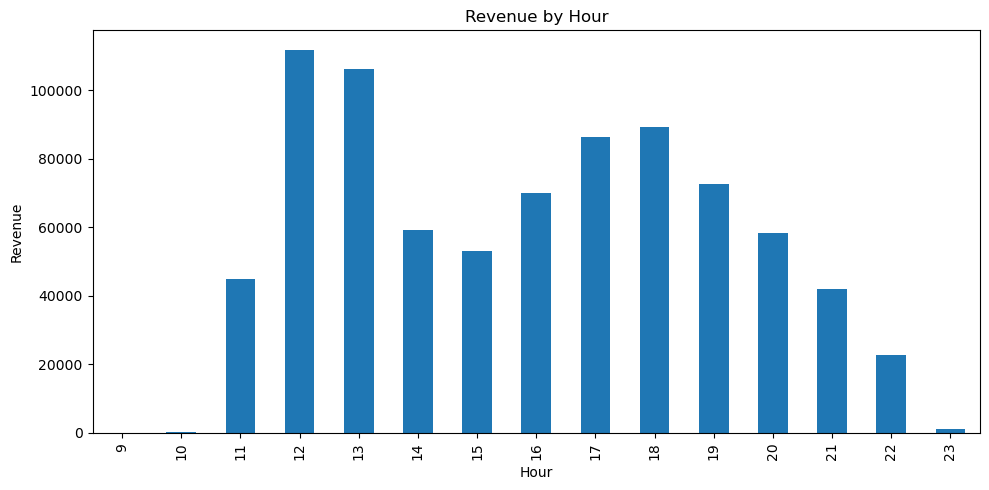

**Top 3 hours by revenue:**

order_hour
12    111877.90
13    106065.70
18     89296.85
Name: line_revenue, dtype: float64

In [8]:

rev_by_hour = df.groupby('order_hour', dropna=True)['line_revenue'].sum().sort_index()
# plot
ax = rev_by_hour.plot(kind='bar', title='Revenue by Hour', xlabel='Hour', ylabel='Revenue')
plt.tight_layout()
plt.savefig(OUT_PLOTS / 'revenue_by_hour.png')
plt.show()

# show top 3 peak hours
top_hours = rev_by_hour.sort_values(ascending=False).head(3)
display(Markdown('**Top 3 hours by revenue:**'))
display(top_hours)


## Sales by day of week
Compute total sales per weekday and identify the best day.

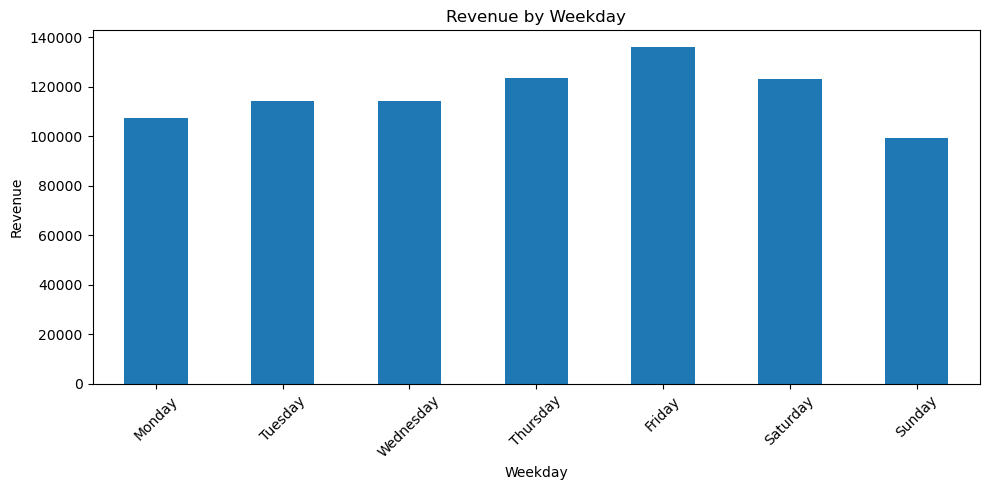

**Best day by revenue:** Friday

In [9]:

rev_by_weekday = df.groupby('order_weekday', dropna=True)['line_revenue'].sum()
weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
rev_by_weekday = rev_by_weekday.reindex(weekdays).fillna(0)

ax = rev_by_weekday.plot(kind='bar', title='Revenue by Weekday', xlabel='Weekday', ylabel='Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(OUT_PLOTS / 'revenue_by_weekday.png')
plt.show()

best_day = rev_by_weekday.idxmax()
display(Markdown(f"**Best day by revenue:** {best_day}"))


## Top 5 bestselling pizzas
Find the top 5 pizzas by quantity sold.

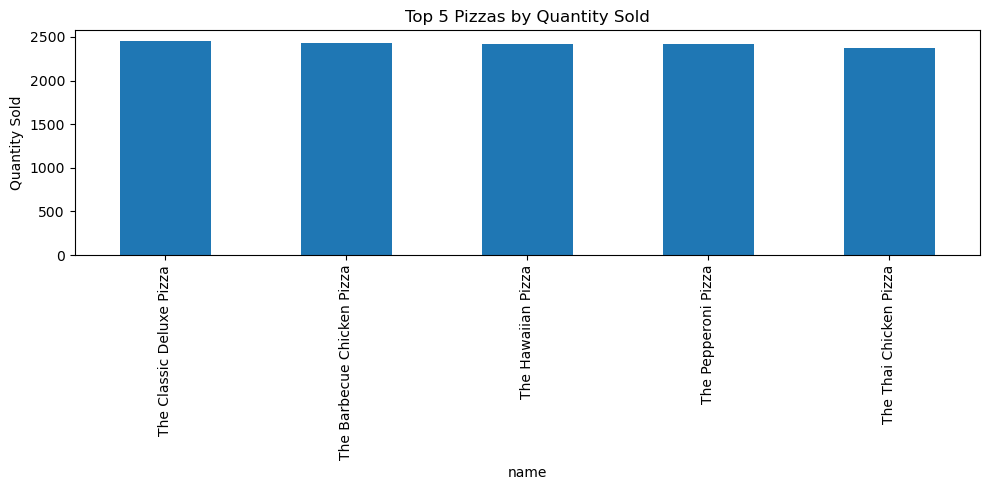

name
The Classic Deluxe Pizza        2453
The Barbecue Chicken Pizza      2432
The Hawaiian Pizza              2422
The Pepperoni Pizza             2418
The Thai Chicken Pizza          2371
The California Chicken Pizza    2370
The Sicilian Pizza              1938
The Spicy Italian Pizza         1924
The Southwest Chicken Pizza     1917
The Big Meat Pizza              1914
Name: quantity, dtype: int64

In [10]:

top5 = df.groupby('name')['quantity'].sum().sort_values(ascending=False).head(10)
ax = top5.head(5).plot(kind='bar', title='Top 5 Pizzas by Quantity Sold', ylabel='Quantity Sold')
plt.tight_layout()
plt.savefig(OUT_PLOTS / 'top5_pizzas.png')
plt.show()

display(top5.head(10))


## Sales by month (trend)
Plot month-over-month revenue to look for trends.

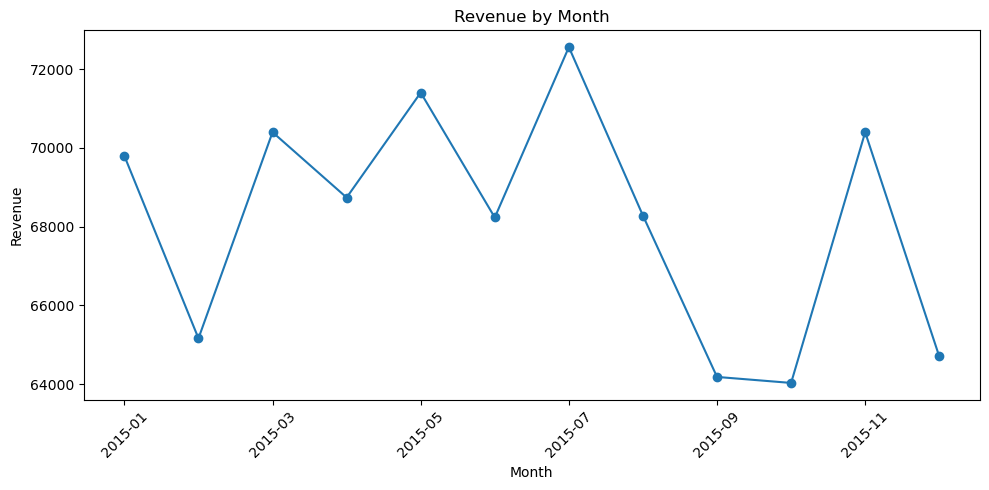

order_month
2015-01    69793.30
2015-02    65159.60
2015-03    70397.10
2015-04    68736.80
2015-05    71402.75
2015-06    68230.20
2015-07    72557.90
2015-08    68278.25
2015-09    64180.05
2015-10    64027.60
2015-11    70395.35
2015-12    64701.15
Name: line_revenue, dtype: float64

In [11]:

rev_by_month = df.groupby('order_month')['line_revenue'].sum().sort_index()
ax = rev_by_month.plot(kind='line', marker='o', title='Revenue by Month', xlabel='Month', ylabel='Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(OUT_PLOTS / 'revenue_by_month.png')
plt.show()

display(rev_by_month)


## Underperforming pizza types
Identify pizza types contributing less than a chosen percentage of total revenue (default 5%).

In [12]:

# Determine a reasonable type name column
candidates = ['pizza_type', 'category', 'name_type', 'type', 'pizza_type_name', 'pizza_type_id']
type_col = next((c for c in candidates if c in df.columns), None)
if type_col is None:
    type_col = 'pizza_type_id' if 'pizza_type_id' in df.columns else df.columns[-1]

sales_by_type = df.groupby(type_col)['line_revenue'].sum().sort_values(ascending=False)
sales_by_type_pct = (sales_by_type / total_revenue * 100).round(2)
threshold = 5.0
underperform = sales_by_type_pct[sales_by_type_pct < threshold]

display(Markdown('### Sales by pizza type (top 20)'))
display(sales_by_type_pct.head(20))

display(Markdown(f'### Underperforming types (< {threshold}% revenue)'))
display(underperform.sort_values())


### Sales by pizza type (top 20)

category
Classic    26.91
Supreme    25.46
Chicken    23.96
Veggie     23.68
Name: line_revenue, dtype: float64

### Underperforming types (< 5.0% revenue)

Series([], Name: line_revenue, dtype: float64)

## Additional exploration
Heatmap of revenue by weekday vs hour and a price distribution plot.

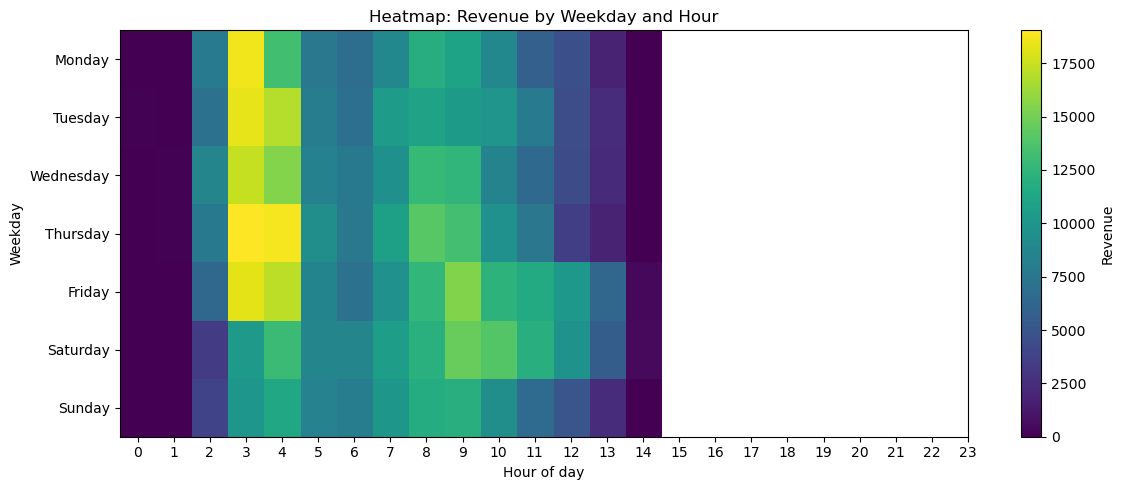

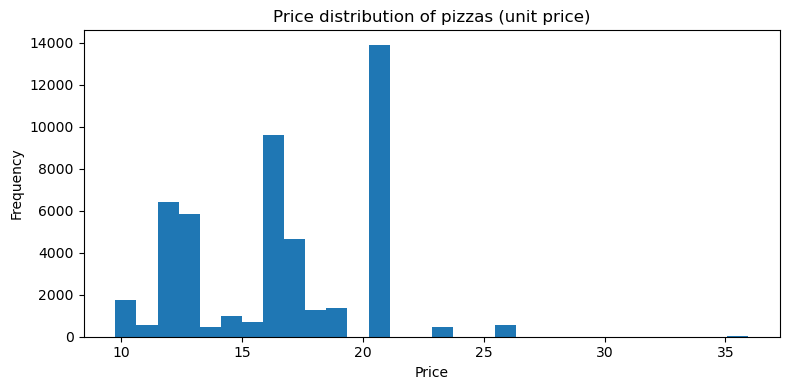

In [15]:

# Heatmap pivot: weekday x hour
pivot = df.pivot_table(index='order_weekday', columns='order_hour', values='line_revenue', aggfunc='sum').reindex(weekdays)
pivot = pivot.fillna(0)

plt.figure(figsize=(12,5))
plt.imshow(pivot, aspect='auto', interpolation='nearest')
plt.colorbar(label='Revenue')
plt.yticks(range(len(pivot.index)), pivot.index)
plt.xticks(range(0,24), range(0,24))
plt.xlabel('Hour of day')
plt.ylabel('Weekday')
plt.title('Heatmap: Revenue by Weekday and Hour')
plt.tight_layout()
plt.savefig(OUT_PLOTS / 'heatmap_weekday_hour.png')
plt.show()

# Price distribution
if 'price' in df.columns:
    plt.figure(figsize=(8,4))
    df['price'].dropna().plot(kind='hist', bins=30)
    plt.title('Price distribution of pizzas (unit price)')
    plt.xlabel('Price')
    plt.tight_layout()
    plt.savefig(OUT_PLOTS / 'price_distribution.png')
    plt.show()


## Conclusions & next steps
- Summarize findings (revenue, peak hours, top pizzas, underperformers).
- Consider promotions for underperforming types, staff scheduling for peak hours, and menu optimization.